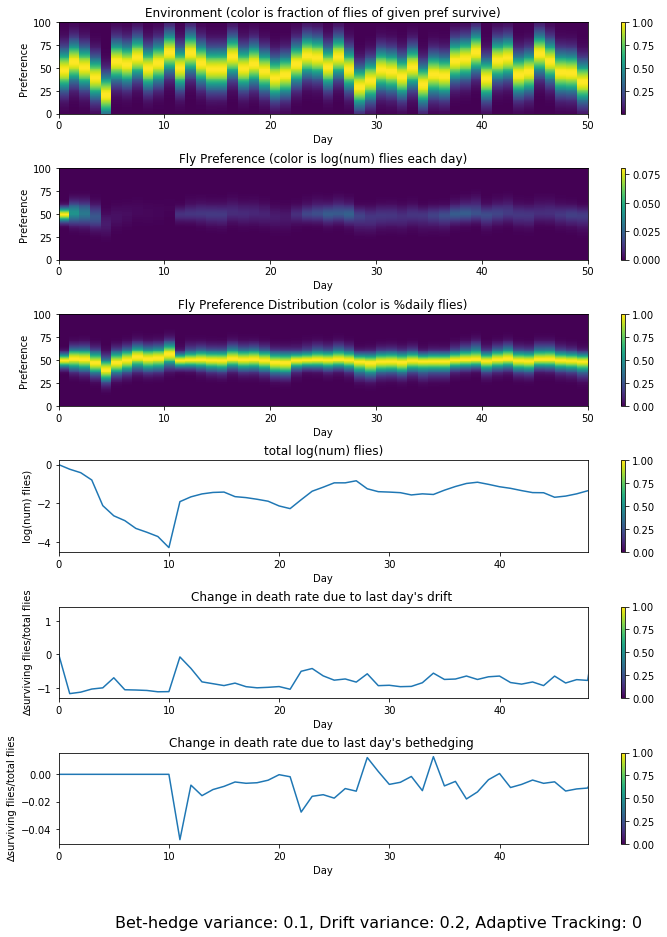

In [9]:
import numpy as np
import scipy.stats as sci
import matplotlib.pyplot as plt
import time
import math
import os
import scipy.stats as stat
import colorednoise as cn
import csv

def npzgraph(driftvariance, betadvantage):
    #np.savez('Matrices/da'+ str(driftvariance)+'ba'+ str(betadvantage)+'.npz')
    data=np.load(os.path.join('./Matrices/da'+ str(driftvariance)+'ba'+ str(betadvantage)+'.npz'))
    dataparameters=np.load(os.path.join('./Matrices/da'+ str(driftvariance)+'ba'+ str(betadvantage)+'parameters.npz'))
    dataenvi=np.load(os.path.join('./Matrices/da'+ str(driftvariance)+'ba'+ str(betadvantage)+'envi.npz'))
    datapref=np.load(os.path.join('./Matrices/da'+ str(driftvariance)+'ba'+ str(betadvantage)+'pref.npz'))
    
    fig, (ax0, ax1,  ax1d, ax2, ax3, ax4) = plt.subplots(6, 1)
    fig.set_figwidth(10)
    fig.set_figheight(12)
    fig.tight_layout()
    plt.subplots_adjust(hspace=.6)
    c=ax0.pcolormesh(dataenvi['envi'])
    fig.colorbar(c,ax=ax0)
    ax0.set_title('Environment (color is fraction of flies of given pref survive)')
    ax0.set_ylabel('Preference')
    ax0.set_xlabel('Day')

    c=ax1.pcolormesh(datapref['pref2'])
    fig.colorbar(c,ax=ax1)
    ax1.set_title('Fly Preference (color is log(num) flies each day)')
    ax1.set_ylabel('Preference')
    ax1.set_xlabel('Day')

    c=ax1d.pcolormesh(datapref['pref2']/np.max(datapref['pref2'],axis=0))
    fig.colorbar(c,ax=ax1d)
    ax1d.set_title('Fly Preference Distribution (color is %daily flies)')
    ax1d.set_ylabel('Preference')
    ax1d.set_xlabel('Day')

    ax2.plot(np.log(datapref['pref02']))
    ax2.set_title('total log(num) flies)') # lowest value is 0.0001 (prefvariance = 0.01 with percent bh=0.01)
    ax2.set_ylabel('log(num) flies)')
    ax2.set_xlabel('Day')
    ax2.set_xlim(0,max(data['daynumber']))

    # ax3.plot(driftadvantage)
    ax3.plot(data['driftadvantage']/datapref['pref02'])
    ax3.set_title('Change in death rate due to last day\'s drift ')
    ax3.set_ylabel('∆surviving flies/total flies')
    ax3.set_xlabel('Day')
    ax3.set_xlim(0,max(data['daynumber']))

    ax4.plot(data['betadvantage']/datapref['pref02'])
    ax4.set_title('Change in death rate due to last day\'s bethedging ')
    ax4.set_ylabel('∆surviving flies/total flies')
    ax4.set_xlabel('Day')
    ax4.set_xlim(0,max(data['daynumber']))

    fig.colorbar(c,ax=ax2)
    fig.colorbar(c,ax=ax3)
    fig.colorbar(c,ax=ax4)

    fig.suptitle('Bet-hedge variance: '+str(dataparameters['prefvariance'])+', Drift variance: '+str(dataparameters['driftvariance'])+', Adaptive Tracking: '+str(dataparameters['adaptivetracking']), y=-.05, fontsize=16)

    plt.show()

npzgraph(0.2,0.0)

In [ ]:
csvgraph(.2,0.0)

In [ ]:
import pandas as pd
hi=np.zeros((0,pd.read_csv('Matrices/da0.2ba0.0parameters.csv',usecols=[8])))
print(hi)
pd.read_csv('Matrices/da0.2ba0.0parameters.csv',usecols=[8])


In [ ]:
import pandas as pd
df = pd.read_csv('Matrices/da0.2ba0.0parameters.csv')
saved_column = df.days
print(saved_column)

In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import simpledrift as sd
import math
from joblib import Parallel, delayed
import os

q=0.2

csvfile = csv.reader(open('Matrices/driftadvantage' + str(q)+ '.csv','r'))
newfile = open('trial.txt','w')

readmatrix = np.genfromtxt('Matrices/driftadvantage' + str(q)+ '.csv')
print(readmatrix)
newfile.write(str(row))

for row in csvfile:
    hi = np.array((row))
    print(hi[0])
    newfile.write(str(row))
#     if i==t
#         print(t)
#         place = t[4]
#         print(place)
#         outputfile.write(place+'\n')
#     i+=1

['finalpopulations', 'envifull', 'envimean', 'y_prefvariancemesh', 'x_driftvariancemesh']


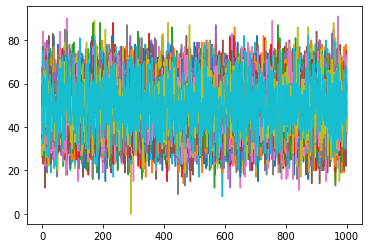

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sci
import matplotlib.pyplot as plt
import time
import math
import os
import scipy.stats as stat
import colorednoise as cn
import csv

x=np.load('/Users/athenaye/Desktop/FinalPopulationAndEnv1000runs_2_20_21.npz')
print(x.files)
plt.plot(x['envimean'])